# Кластеризация
В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять,
в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов
к задаче уменьшения цветности изображения.

In [3]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn
from heapq import heapify, heappop, heappush, heappushpop
from scipy.spatial import distance_matrix
import seaborn as sns
sns.set()

In [34]:
def visualize_clasters(X, labels, n_clusters=4):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(4, 4))
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

In [284]:
def visualize_it(algorithm, n_dataset = 1):
    if n_dataset == 1:
        X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]], random_state=42)
        n_clusters = 4
        dbscan_eps, min_samples = 0.5, 1
    elif n_dataset == 2:
        X, true_labels = make_moons(400, noise=0.075, random_state=42)
        n_clusters = 2
        dbscan_eps, min_samples = 0.2, 5

    if algorithm == 'KMeans':    
        data = {'sample': None, 'random': None, 'k-means++': None}
        for method in data.keys():
            data[method] = KMeans(n_clusters=n_clusters, init = method).fit(X).predict(X)
    elif algorithm == 'DBScan':
        data = {'euclidean': None, 'manhattan': None, 'chebyshev': None}
        for method in data.keys():
            data[method] = DBScan(metric = method, eps=dbscan_eps, min_samples = min_samples).fit_predict(X)

    elif algorithm == 'AgglomertiveClustering':
        data = {'average': None, 'single': None, 'complete': None}
        for method in data.keys():
            data[method] = AgglomertiveClustering(n_clusters=n_clusters, linkage = method).fit_predict(X)

    fig, axis = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    fig.suptitle(f"{algorithm}")
    sns.scatterplot(ax = axis[0], x = X[:, 0], y = X[:, 1], s = 100, hue = true_labels).set_title('True labels')

    for i in range(1, 4):
        method, labels = data.popitem()
        sns.scatterplot(ax = axis[i], x = X[:, 0], y = X[:, 1], s = 100, hue = labels).set_title(method)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать — метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

Не забудте реинициализировать пустые кластеры!


In [67]:
def euclidean_distance(X: np.array, centroids: np.array, sqrt: bool = True):
    """
    Considering the rows of centroids as vectors, compute the
    distance matrix between each pair of centroid and observation X (rows)

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
    centroids : ndarray of shape (n_samples, n_clusters)
    sqrt : bool if False return squared distances

    Return
    ----------
    distances : ndarray of shape (n_samples, n_clusters)

    """
    if X[0].shape == centroids.shape:
        distances = np.linalg.norm(X - centroids, axis=1)[:, np.newaxis]
    else:
        n_samples, _ = X.shape
        distances = np.array([np.linalg.norm(X - center, axis=1)
                              for center in centroids]).transpose()

    if not sqrt:
        return distances ** 2
    return distances

In [211]:
class KMeans:
    """K-Means clustering.

    Parameters
    ----------
    n_clusters : int
        number of clusters to form
    init : str
        Method for initialization:
        1. random --- centroids initialized as random points,
        2. sample --- centroids are chosen at random from data ,
        3. k-means++ --- initial centroids selected using K-means++ methods.
    max_iter : int
        Maximum number of kmeans iterations.
    tol : float
        Tolerance with regards to Frobenius norm of the difference
        in the cluster centers of two consecutive iterations to declare
        convergence.
    verbose : bool
        Verbose mode

    """

    def __init__(self, n_clusters: int, init: str,
                 max_iter: int = 600, tol: float = 1e-4, verbose: bool = False):
        self.init = init
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    # noinspection PyShadowingNames
    def _init_centroids(self, X):
        """
        Computational component for initialization of n_clusters by
        k-means++.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)

        Return
        ----------
        centroids : ndarray of shape (n_samples, n_clusters)
            The initial centers for k-means.
        """
        n_samples, n_features = X.shape
        centroids = np.empty((self.n_clusters, n_features), dtype=X.dtype)
        if self.init == 'kmeans++':

            index_id = np.random.randint(n_samples)
            centroids[0] = X[index_id]

            for c in range(1, self.n_clusters):
                closest_dist = np.min(euclidean_distance(X, centroids[:c, :], sqrt=False), axis=1)
                pick_random = np.random.random() * np.sum(closest_dist)
                cum_sum_dist = np.cumsum(closest_dist)
                cent_id = np.searchsorted(np.cumsum(closest_dist), v=pick_random, side='right')
                cent_id = np.clip(cent_id, 0, cum_sum_dist.size - 1)
                centroids[c] = X[cent_id]

        elif self.init == 'sample':
            indexes_id = np.random.permutation(n_samples)[:self.n_clusters]
            centroids = X[indexes_id]

        elif self.init == 'random':
            centroids = np.random.random((self.n_clusters, n_features))

        return centroids

    def fit(self, X: np.array, y=None) -> NoReturn:
        """Compute k-means clustering.
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training instances to cluster.
        y : Ignored

        Returns
        -------
        self
            Fitted estimator.
        """
        n_samples, n_features = X.shape
        centroids_new = self._init_centroids(X)
        labels_new = np.argmin(euclidean_distance(X, centroids_new), axis=1)

        while self.max_iter:
            self.max_iter -= 1
            centroids_old = centroids_new
            labels_old = labels_new

            centroids_new = np.empty((self.n_clusters, n_features), dtype=X.dtype)
            for c in range(self.n_clusters):
                indexes = np.where(labels_old == c)
                centroids_new[c] = np.mean(X[indexes], axis=0)

            labels_new = np.argmin(euclidean_distance(X, centroids_new), axis=1)

            # Check tol
            if np.array_equal(labels_old, labels_new):
                if self.verbose:
                    print(f"Converged at iteration {self.max_iter}: strict convergence.")
                break
            else:
                center_shift = np.linalg.norm(centroids_old - centroids_new, axis=1)
                center_shift_tot = (center_shift ** 2).sum()
                if center_shift_tot <= self.tol:
                    if self.verbose:
                        print(
                            f"Converged at iteration {self.max_iter}: center shift "
                            f"{center_shift_tot} within tolerance {self.tol}."
                        )
                break
        if self.verbose:
            print("Maximum of iteration reached")

        self.labels_ = labels_new
        self.centroids_ = centroids_new

        return self

    def predict(self, X: np.array, y=None) -> np.array:
        """Predict the closest cluster each sample in X belongs to.
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.
        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        return self.fit(X).labels_

Протестируйте алгоритм на синтетических данных.
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

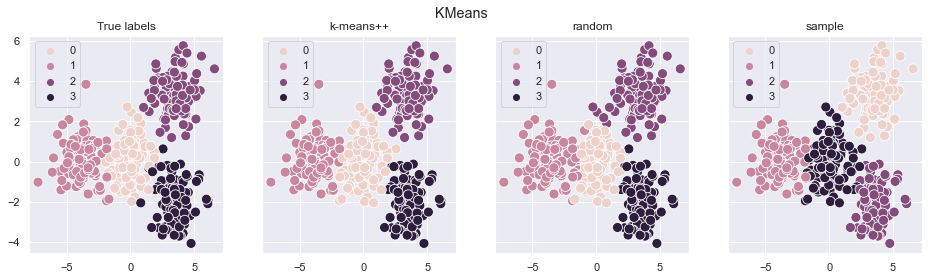

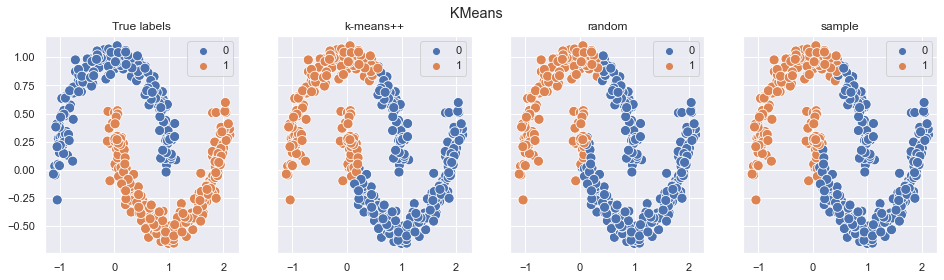

In [221]:
visualize_it(n_dataset = 1, algorithm='KMeans')
visualize_it(n_dataset = 2, algorithm='KMeans')

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные.
Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [180]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "euclidean"):
        """

        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric


    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        n_samples, _ = X.shape
        neighborhoods = KDTree(X, leaf_size=self.leaf_size,
                               metric=self.metric).query_radius(X, r=self.eps)
        n_neigh = np.array([len(neighborhoods[i]) for i in range(n_samples)])
        is_core = np.asarray(n_neigh >= self.min_samples, dtype=np.uint8)

        visited = set()
        labels = np.full(n_samples, -1)
        n_clusters = -1

        for i in range(n_samples):

            if is_core[i] and i not in visited:
                n_clusters += 1
                q = deque([i])

                while q:
                    s = q.popleft()
                    visited.add(s)
                    labels[s] = n_clusters

                    for neigh in neighborhoods[s]:
                        if neigh not in visited:
                            visited.add(neigh)
                            q.append(neigh)
                            labels[neigh] = n_clusters
        return labels

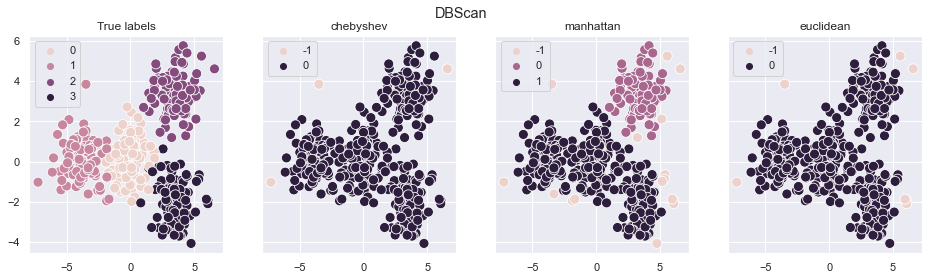

In [280]:
for i in np.arange(0.9, 1.0, 0.1):
    for j in range(5, 6):
        visualize_it(n_dataset = 1, eps_it = i, size_it = j, algorithm='DBScan')
#         print(i, j)
# visualize_it(n_dataset = 2, algorithm='DBScan')

<AxesSubplot:>

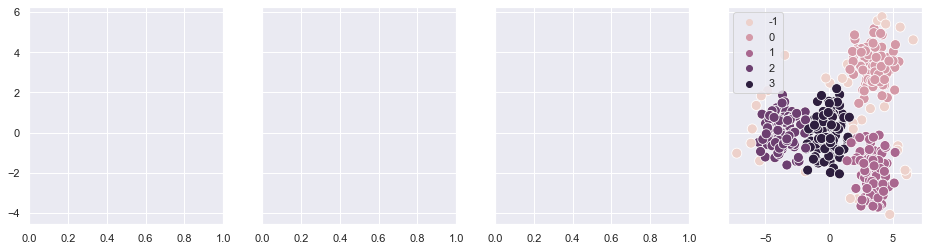

In [285]:
from sklearn.cluster import DBSCAN as DB
import numpy as np
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]], random_state=42)
clustering = DB(eps=0.9, min_samples=15).fit(X)
labels = clustering.labels_
fig, axis = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
sns.scatterplot(x = X[:, 0], y = X[:, 1], s = 100, hue = labels)

Протестируйте алгоритм на синтетических данных.
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между
ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим
только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами.
Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек,
где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек,
где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек,
где одна принадлежит первому кластеру, а другая - второму.

In [163]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """

        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """


        n_samples, _ = X.shape
        clusters = np.arange(n_samples)
        nn_clusters = n_samples

        dist = distance_matrix(X, X)
        dist[np.diag_indices(n_samples)] = np.inf
        max_iter = 100

        while nn_clusters > self.n_clusters:
            max_iter -= 1
            i, j = np.unravel_index(np.argmin(dist), dist.shape)

            if self.linkage == "average":
                dist[i] = dist[:, i] = np.mean((dist[i], dist[j]), axis=0, keepdims=True)
                dist[j] = dist[i, i] = dist[i, j] = np.inf

            elif self.linkage == "single":
                dist[i] = dist[:, i] = np.minimum(dist[i], dist[j])
                dist[j] = dist[:, j] = dist[i, i] = np.inf
            elif self.linkage == "complete":
                dist[i] = dist[:, i] = np.maximum(dist[i], dist[j])
                dist[j] = dist[:, j] = dist[i, i] = np.inf



            clusters[np.where(clusters == j)] = i
            nn_clusters = np.unique(clusters).size

        self.labels_, k = np.full(n_samples, -1), 0
        for i in np.unique(clusters):
            self.labels_[np.where(clusters == i)] = k
            k += 1

        return self.labels_

Протестируйте алгоритм на синтетических данных.
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

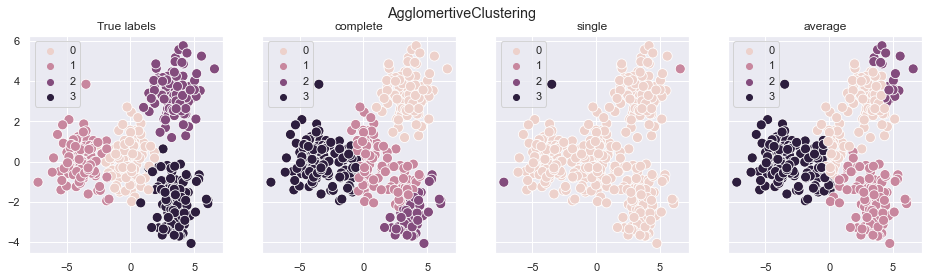

In [293]:
visualize_it(n_dataset = 1, algorithm='AgglomertiveClustering')
# visualize_it(n_dataset = 2, algorithm='AgglomertiveClustering')

<AxesSubplot:>

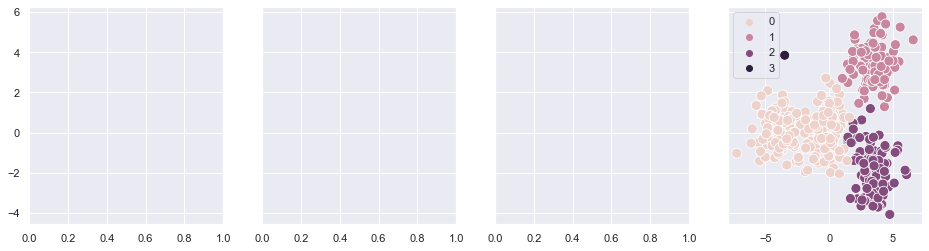

In [295]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]], random_state=42)
# clustering = DB(eps=0.9, min_samples=15).fit(X)
from sklearn.cluster import AgglomerativeClustering as AG
clustering = AG(n_clusters=4, linkage="average").fit(X)
clustering
# linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
clustering.labels_
labels = clustering.labels_

fig, axis = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
sns.scatterplot(x = X[:, 0], y = X[:, 1], s = 100, hue = labels)




In [296]:
# Результаты 
# Дибискан чинить весь 
# Агломератив только average

SyntaxError: invalid syntax (<ipython-input-296-75a944363acb>, line 2)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV.

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [ ]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.

    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C),
        где N и M - размеры изображения,
        а C - количество цветов (3 для обычного изображения).
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    matplotlib.image.imsave(path, image)

In [ ]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, **kwargs):
    cluster_colors = None # color of each cluster
    clusters = None # Cluster labels for each pixel in flattened image
    recolored = None # Image with pixel colors assigned to corresponding cluster colors

    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored



def clusterize_image(image, n_clusters=3):
    im_vec = image.reshape(-1, image.shape[-1])
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(im_vec)
    clusters = kmeans.predict(im_vec)
    recolored = im_vec
    cluster_colors = [np.mean(im_vec[clusters == cl], axis=0) for cl in range(n_clusters)]

    for cl in range(n_clusters):
        recolored[clusters == cl] = cluster_colors[cl]
    recolored = recolored.reshape(image.shape)
    clusters_statistics(image.reshape(-1, 3) / 255, np.array(cluster_colors) / 255, clusters)  # Very slow (:
    return recolored

In [ ]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")

